## Life expectancy prediction
The primary goal of this project is to assess and analyze global life expectancy trends. The study aims to offer a concise and visually accessible representation of the analysis of recent years' life expectancy data worldwide, intended for the general public and relevant authorities. The life expectancy data collected between the years 2000 and 2015 can be compared and further inferred with various factors including changes over the years, adult mortality, infant deaths, total expenditure, Gross Domestic Product and so on. With the data analyzed, we can compare the average life expectancy in each country and identify the key factor behind the trend. Through this project, we hoped 

1. To derive actionable insights from a massive dataset of life expectancy in the world.

2. To conduct an analysis of the relationship between the factors and life expectancy.

3. To compare differences in life expectancy and the factor contributing to it in each country.


## Importing Library

In [138]:
# Libraries Import
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
import math

## Data Importing dan Data Cleaning

In [139]:
# Dataset Import
df = pd.read_csv('./Life Expectancy Data.csv')

In [140]:
rows, cols = df.shape
print("Records:", rows)

Records: 2938


In [141]:
print('\nLife Expectancy Factors:', cols, list(df.columns))
print('\nNumber of Countries:', len(df['Country'].unique()))
print('\nPeriod: %s - %s'%(min(df['Year']), max(df['Year'])))


Life Expectancy Factors: 22 ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']

Number of Countries: 193

Period: 2000 - 2015


In [142]:
df.apply(lambda x: len(x.unique())) 

Country                             193
Year                                 16
Status                                2
Life expectancy                     363
Adult Mortality                     426
infant deaths                       209
Alcohol                            1077
percentage expenditure             2328
Hepatitis B                          88
Measles                             958
 BMI                                609
under-five deaths                   252
Polio                                74
Total expenditure                   819
Diphtheria                           82
 HIV/AIDS                           200
GDP                                2491
Population                         2279
 thinness  1-19 years               201
 thinness 5-9 years                 208
Income composition of resources     626
Schooling                           174
dtype: int64

In [143]:
df[df.duplicated()]  

Empty DataFrame
Columns: [Country, Year, Status, Life expectancy , Adult Mortality, infant deaths, Alcohol, percentage expenditure, Hepatitis B, Measles ,  BMI , under-five deaths , Polio, Total expenditure, Diphtheria ,  HIV/AIDS, GDP, Population,  thinness  1-19 years,  thinness 5-9 years, Income composition of resources, Schooling]
Index: []

[0 rows x 22 columns]

In [144]:
# Missing Values Count & Percentage
null_vals = df.isna().sum().reset_index()
null_vals.columns = ['Factors', 'Missing Values']
null_vals["Missing %"] = round(null_vals['Missing Values']/rows*100, 2)
null_vals[ null_vals['Missing %'] > 0 ]

Factors  Missing Values  Missing %
3                  Life expectancy               10       0.34
4                   Adult Mortality              10       0.34
6                           Alcohol             194       6.60
8                       Hepatitis B             553      18.82
10                             BMI               34       1.16
12                            Polio              19       0.65
13                Total expenditure             226       7.69
14                      Diphtheria               19       0.65
16                              GDP             448      15.25
17                       Population             652      22.19
18             thinness  1-19 years              34       1.16
19               thinness 5-9 years              34       1.16
20  Income composition of resources             167       5.68
21                        Schooling             163       5.55

In [145]:
# Space and Case Correction
df.rename(columns={'Life expectancy ': 'Life Expectancy',
                   'infant deaths': 'Infant Deaths',
                   'percentage expenditure': 'Percentage Expenditure',
                   'Measles ': 'Measles',
                   ' BMI ': 'BMI',
                   'under-five deaths ': 'Under Five Deaths',
                   'Diphtheria ': 'Diphtheria Vaccination %',
                   ' HIV/AIDS': 'HIV/AIDS',
                   ' thinness  1-19 years': 'Thinness 10-19 years',
                   ' thinness 5-9 years': 'Thinness 5-9 years',
                   'Income composition of resources': 'Resources Income Composition',
                   'Total expenditure': 'Total Expenditure',
                   'Polio': 'Pol3 Vaccination %',
                   'Hepatitis B': 'HepB Vaccination %', 
                   'Alcohol': 'Alcohol Intake(L)'
                  },inplace=True)
df.columns

Index(['Country', 'Year', 'Status', 'Life Expectancy', 'Adult Mortality',
       'Infant Deaths', 'Alcohol Intake(L)', 'Percentage Expenditure',
       'HepB Vaccination %', 'Measles', 'BMI', 'Under Five Deaths',
       'Pol3 Vaccination %', 'Total Expenditure', 'Diphtheria Vaccination %',
       'HIV/AIDS', 'GDP', 'Population', 'Thinness 10-19 years',
       'Thinness 5-9 years', 'Resources Income Composition', 'Schooling'],
      dtype='object')

In [146]:
# Data Formatting
df['Country'] = df['Country'].astype('string')
df['Status'] = df['Status'].astype('string')
df.dtypes

Country                         string[python]
Year                                     int64
Status                          string[python]
Life Expectancy                        float64
Adult Mortality                        float64
Infant Deaths                            int64
Alcohol Intake(L)                      float64
Percentage Expenditure                 float64
HepB Vaccination %                     float64
Measles                                  int64
BMI                                    float64
Under Five Deaths                        int64
Pol3 Vaccination %                     float64
Total Expenditure                      float64
Diphtheria Vaccination %               float64
HIV/AIDS                               float64
GDP                                    float64
Population                             float64
Thinness 10-19 years                   float64
Thinness 5-9 years                     float64
Resources Income Composition           float64
Schooling    

In [147]:
nan_country_names = df[df['Life Expectancy'].isna()]['Country']
nan_country_names.value_counts()

[df[df['Country']==cou] for cou in nan_country_names]

ind_to_romove = [df[df['Country']==cou].index[0] for cou in nan_country_names]
df = df.drop(ind_to_romove,axis=0).reset_index(drop=True)

In [148]:
# Dealing with Missing Values (replacing with mean value for the year)
null_col = ('Life Expectancy', 'Adult Mortality', 'Alcohol Intake(L)', 'HepB Vaccination %', 'BMI', 'Pol3 Vaccination %', 'Total Expenditure', 'Diphtheria Vaccination %', 'GDP', 'Population', 'Thinness 10-19 years', 'Thinness 5-9 years', 'Resources Income Composition', 'Schooling')
data_valid = []
for year in list(df.Year.unique()):
    year_data = df[df.Year == year].copy()
    for col in null_col:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    data_valid.append(year_data)
df = pd.concat(data_valid).copy()
df.isnull().sum(axis = 0)

Country                         0
Year                            0
Status                          0
Life Expectancy                 0
Adult Mortality                 0
Infant Deaths                   0
Alcohol Intake(L)               0
Percentage Expenditure          0
HepB Vaccination %              0
Measles                         0
BMI                             0
Under Five Deaths               0
Pol3 Vaccination %              0
Total Expenditure               0
Diphtheria Vaccination %        0
HIV/AIDS                        0
GDP                             0
Population                      0
Thinness 10-19 years            0
Thinness 5-9 years              0
Resources Income Composition    0
Schooling                       0
dtype: int64

In [149]:
# Label Encoding (transform non-numerical labels to numerical labels)
df['Status'] = LabelEncoder().fit_transform(df['Status'])
df['Status']

0       1
16      1
32      1
48      1
64      1
       ..
2863    1
2879    1
2895    1
2911    1
2927    1
Name: Status, Length: 2928, dtype: int64

In [150]:
# Data Normalization/ Feature Scaling
#df_scale = df.drop(['Country', 'Status', 'Year'], axis='columns')
#df_scale = MinMaxScaler().fit_transform(df_scale)
for col in df.columns:
    if col not in ('Country', 'Status', 'Year'):
        df[col] = df[col] / df[col].max()
df

Country  Year  Status  Life Expectancy   
0                            Afghanistan  2015       1         0.730337  \
16                               Albania  2015       1         0.874157   
32                               Algeria  2015       1         0.849438   
48                                Angola  2015       1         0.588764   
64                   Antigua and Barbuda  2015       1         0.858427   
...                                  ...   ...     ...              ...   
2863  Venezuela (Bolivarian Republic of)  2000       1         0.814607   
2879                            Viet Nam  2000       1         0.824719   
2895                               Yemen  2000       1         0.764045   
2911                              Zambia  2000       1         0.492135   
2927                            Zimbabwe  2000       1         0.516854   

      Adult Mortality  Infant Deaths  Alcohol Intake(L)   
0            0.363762       0.034444           0.000560  \
16           0.102351       0.000000           0.257415   
32           0.026279       0.011667           0.295934   
48           0.463347       0.036667           0.295934   
64           0.017981       0.000000           0.295934   
...               ...            ...                ...   
2863         0.232365       0.006111           0.448237   
2879         0.192254       0.018333           0.089536   
2895         0.348548       0.026667           0.003917   
2911         0.849239       0.024444           0.146614   
2927         0.919779       0.013333           0.094012   

      Percentage Expenditure  HepB Vaccination %   Measles  ...   
0                   0.003659            0.656566  0.005439  ...  \
16                  0.018736            1.000000  0.000000  ...   
32                  0.000000            0.959596  0.000297  ...   
48                  0.000000            0.646465  0.000556  ...   
64                  0.000000            1.000000  0.000000  ...   
...                      ...                 ...       ...  ...   
2863                0.000000            0.050505  0.000104  ...   
2879                0.000000            0.747831  0.077820  ...   
2895                0.000000            0.141414  0.000000  ...   
2911                0.002342            0.747831  0.145770  ...   
2927                0.000000            0.797980  0.006989  ...   

      Pol3 Vaccination %  Total Expenditure  Diphtheria Vaccination %   
0               0.060606           0.463636                  0.656566  \
16              1.000000           0.340909                  1.000000   
32              0.959596           0.402273                  0.959596   
48              0.070707           0.402273                  0.646465   
64              0.868687           0.402273                  1.000000   
...                  ...                ...                       ...   
2863            0.868687           0.278977                  0.777778   
2879            0.969697           0.277841                  0.969697   
2895            0.747475           0.235227                  0.747475   
2911            0.858586           0.406818                  0.858586   
2927            0.787879           0.403409                  0.787879   

      HIV/AIDS       GDP  Population  Thinness 10-19 years   
0     0.001976  0.004903    0.026074              0.620939  \
16    0.001976  0.033181    0.000022              0.043321   
32    0.001976  0.034679    0.030816              0.216606   
48    0.037549  0.031012    0.002153              0.299639   
64    0.003953  0.113843    0.008577              0.119134   
...        ...       ...         ...                   ...   
2863  0.001976  0.039510    0.007296              0.064982   
2879  0.001976  0.039510    0.007296              0.570397   
2895  0.001976  0.039510    0.007296              0.509025   
2911  0.369565  0.002869    0.001183              0.270758   
2927  0.859684  0.004593    0.009446              0.397112 

In [151]:
# Rounding Float Values to 4 Decimals
for col in df:
    if df[col].dtype in (np.int64, np.float64):
        df[col] = round(df[col], 4)
df

Country  Year  Status  Life Expectancy   
0                            Afghanistan  2015       1           0.7303  \
16                               Albania  2015       1           0.8742   
32                               Algeria  2015       1           0.8494   
48                                Angola  2015       1           0.5888   
64                   Antigua and Barbuda  2015       1           0.8584   
...                                  ...   ...     ...              ...   
2863  Venezuela (Bolivarian Republic of)  2000       1           0.8146   
2879                            Viet Nam  2000       1           0.8247   
2895                               Yemen  2000       1           0.7640   
2911                              Zambia  2000       1           0.4921   
2927                            Zimbabwe  2000       1           0.5169   

      Adult Mortality  Infant Deaths  Alcohol Intake(L)   
0              0.3638         0.0344             0.0006  \
16             0.1024         0.0000             0.2574   
32             0.0263         0.0117             0.2959   
48             0.4633         0.0367             0.2959   
64             0.0180         0.0000             0.2959   
...               ...            ...                ...   
2863           0.2324         0.0061             0.4482   
2879           0.1923         0.0183             0.0895   
2895           0.3485         0.0267             0.0039   
2911           0.8492         0.0244             0.1466   
2927           0.9198         0.0133             0.0940   

      Percentage Expenditure  HepB Vaccination %  Measles  ...   
0                     0.0037              0.6566   0.0054  ...  \
16                    0.0187              1.0000   0.0000  ...   
32                    0.0000              0.9596   0.0003  ...   
48                    0.0000              0.6465   0.0006  ...   
64                    0.0000              1.0000   0.0000  ...   
...                      ...                 ...      ...  ...   
2863                  0.0000              0.0505   0.0001  ...   
2879                  0.0000              0.7478   0.0778  ...   
2895                  0.0000              0.1414   0.0000  ...   
2911                  0.0023              0.7478   0.1458  ...   
2927                  0.0000              0.7980   0.0070  ...   

      Pol3 Vaccination %  Total Expenditure  Diphtheria Vaccination %   
0                 0.0606             0.4636                    0.6566  \
16                1.0000             0.3409                    1.0000   
32                0.9596             0.4023                    0.9596   
48                0.0707             0.4023                    0.6465   
64                0.8687             0.4023                    1.0000   
...                  ...                ...                       ...   
2863              0.8687             0.2790                    0.7778   
2879              0.9697             0.2778                    0.9697   
2895              0.7475             0.2352                    0.7475   
2911              0.8586             0.4068                    0.8586   
2927              0.7879             0.4034                    0.7879   

      HIV/AIDS     GDP  Population  Thinness 10-19 years  Thinness 5-9 years   
0       0.0020  0.0049      0.0261                0.6209              0.6049  \
16      0.0020  0.0332      0.0000                0.0433              0.0455   
32      0.0020  0.0347      0.0308                0.2166              0.2028   
48      0.0375  0.0310      0.0022                0.2996              0.2867   
64      0.0040  0.1138      0.0086                0.1191              0.1154   
...        ...     ...         ...                   ...                 ...   
2863    0.0020  0.0395      0.0073                0.0650              0.0594   
2879    0.0020  0.0395      0.0073                0.5704              0.5734   
2895    0.0020  0.0395      0.007

In [152]:
df.describe()  

Year       Status  Life Expectancy  Adult Mortality   
count  2928.00000  2928.000000      2928.000000      2928.000000  \
mean   2007.50000     0.825137         0.777808         0.227934   
std       4.61056     0.379915         0.107009         0.171911   
min    2000.00000     0.000000         0.407900         0.001400   
25%    2003.75000     1.000000         0.709000         0.102400   
50%    2007.50000     1.000000         0.810100         0.199200   
75%    2011.25000     1.000000         0.850600         0.315400   
max    2015.00000     1.000000         1.000000         1.000000   

       Infant Deaths  Alcohol Intake(L)  Percentage Expenditure   
count    2928.000000        2928.000000             2928.000000  \
mean        0.016899           0.260531                0.038005   
std         0.065618           0.219264                0.102205   
min         0.000000           0.000600                0.000000   
25%         0.000000           0.061975                0.000275   
50%         0.001700           0.232800                0.003400   
75%         0.012200           0.414100                0.022725   
max         1.000000           1.000000                1.000000   

       HepB Vaccination %      Measles          BMI  ...  Pol3 Vaccination %   
count         2928.000000  2928.000000  2928.000000  ...         2928.000000  \
mean             0.811507     0.011441     0.492724  ...            0.833693   
std              0.228569     0.054133     0.255819  ...            0.235783   
min              0.010100     0.000000     0.012900  ...            0.030300   
25%              0.748500     0.000000     0.250000  ...            0.787900   
50%              0.878800     0.000100     0.554100  ...            0.939400   
75%              0.969700     0.001700     0.722900  ...            0.979800   
max              1.000000     1.000000     1.000000  ...            1.000000   

       Total Expenditure  Diphtheria Vaccination %     HIV/AIDS          GDP   
count        2928.000000               2928.000000  2928.000000  2928.000000  \
mean            0.340943                  0.831345     0.034555     0.062867   
std             0.136466                  0.238714     0.100500     0.110593   
min             0.021000                  0.020200     0.002000     0.000000   
25%             0.248300                  0.787900     0.002000     0.004875   
50%             0.335500                  0.939400     0.002000     0.026100   
75%             0.416500                  0.979800     0.015800     0.062600   
max             1.000000                  1.000000     1.000000     1.000000   

        Population  Thinness 10-19 years  Thinness 5-9 years   
count  2928.000000           2928.000000         2928.000000  \
mean      0.009867              0.175114            0.170682   
std       0.041689              0.158722            0.156814   
min       0.000000              0.003600            0.003500   
25%       0.000300              0.057800            0.055900   
50%       0.002800              0.122700            0.118900   
75%       0.009100              0.256300            0.251700   
max       1.000000              1.000000            1.000000   

       Resources Income Composition    Schooling  
count                   2928.000000  2928.000000  
mean                       0.661835     0.579692  
std                        0.216775     0.157397  
min                        0.000000     0.000000  
25%                        0.531600     0.497600  
50%                        0.709900     0.594200  
75%                        0.815400     0.681200  
max                        1.000000     1.000000  

[8 rows x 21 columns]

In [153]:
# categorical columns & numerical columns
categ_cols = ['Country', 'Status']
numeric_cols = [] 
for i in df.columns:
    if i != 'Status' and df[i].dtype in (np.float64, np.int64):
        numeric_cols.append(i)

## Exploratory Data Anlaysing

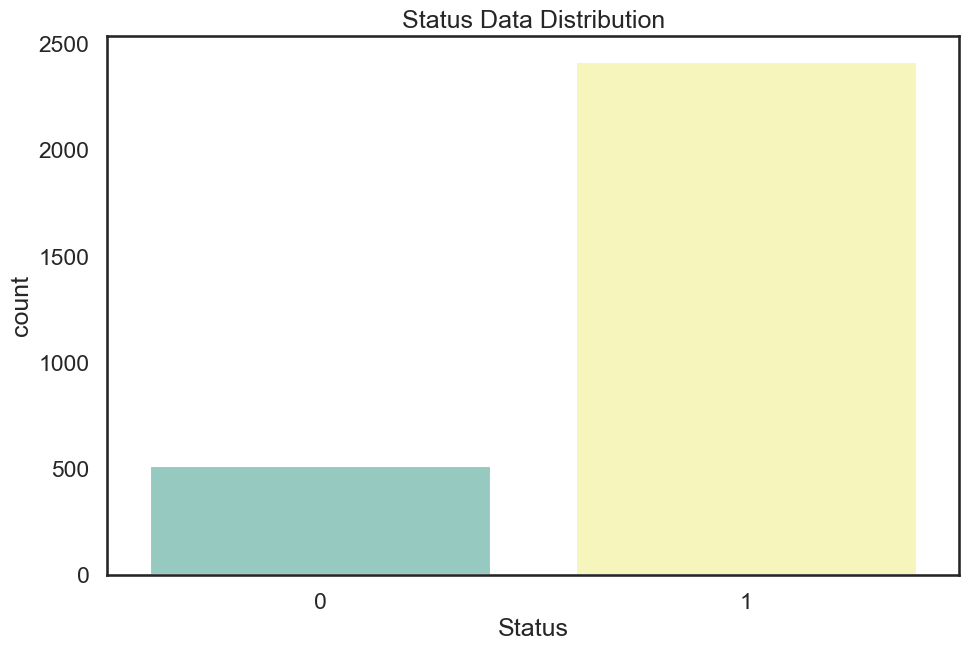

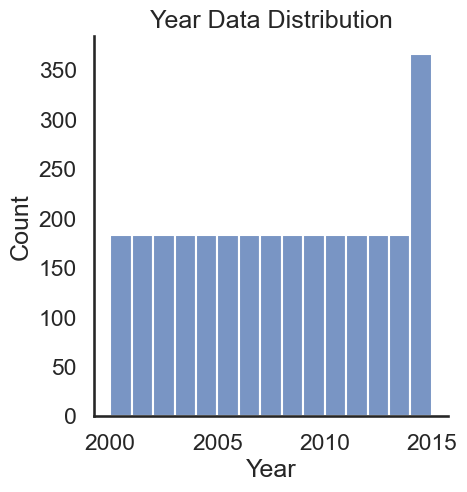

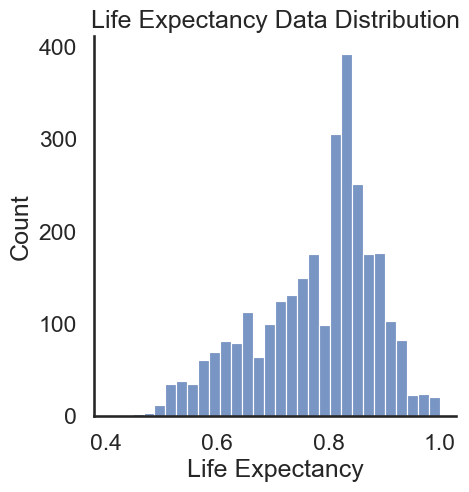

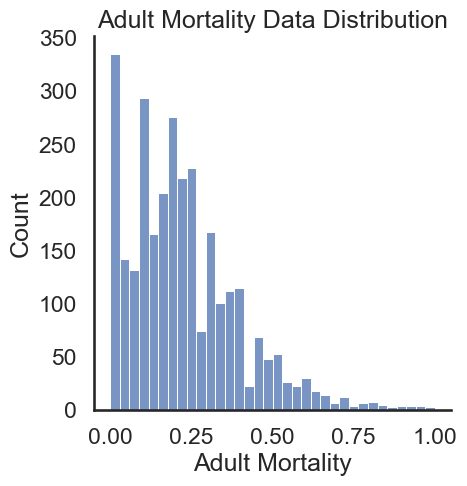

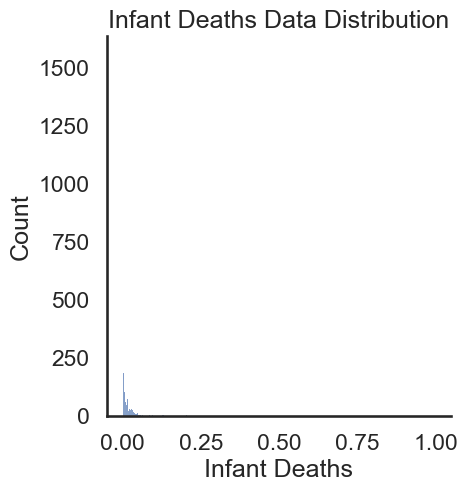

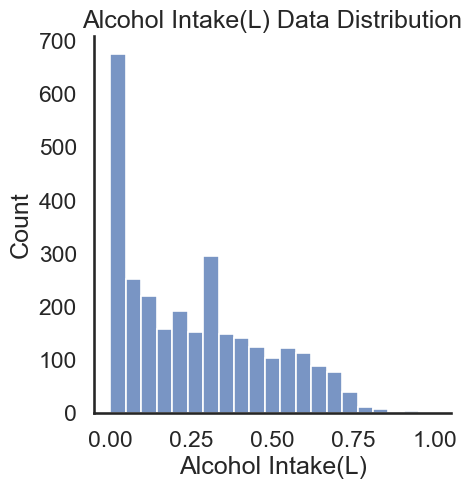

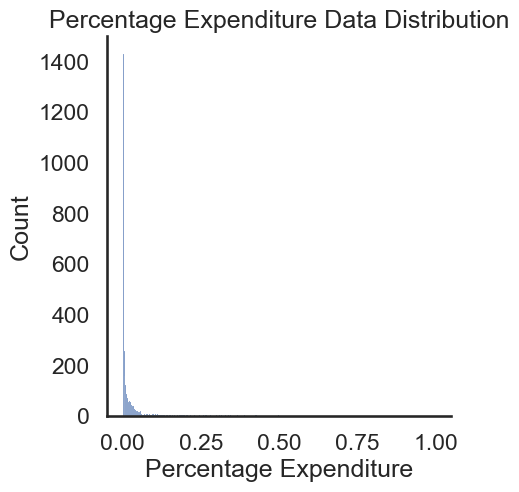

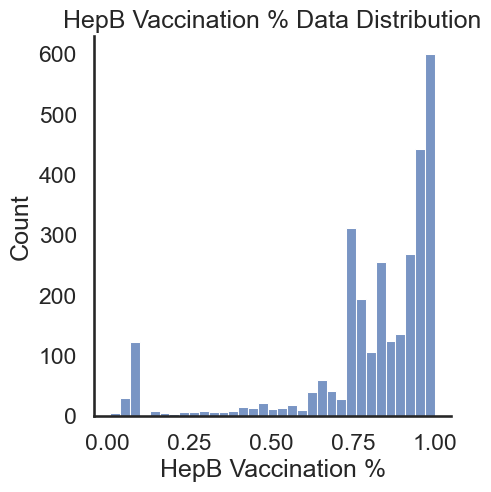

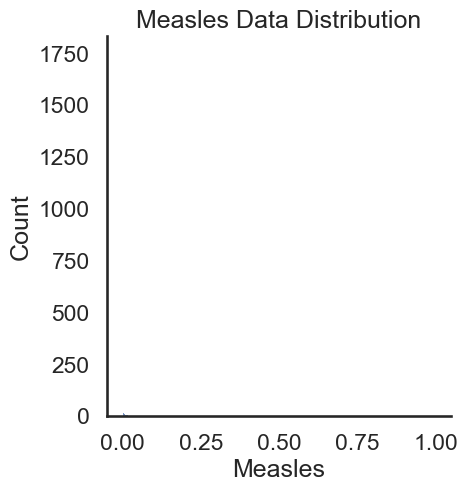

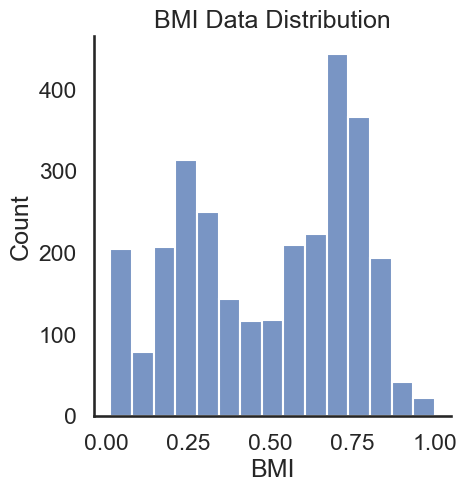

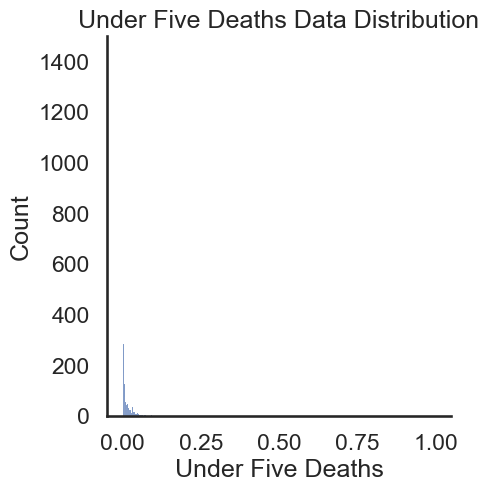

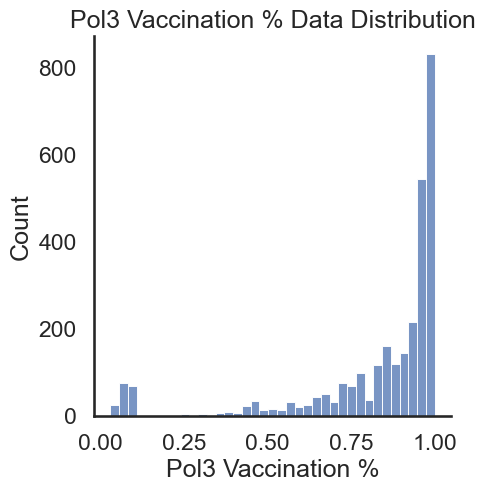

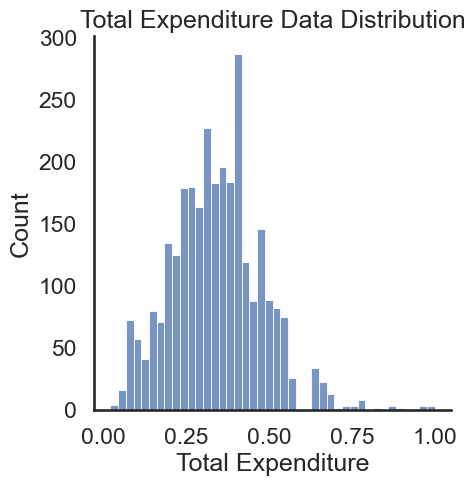

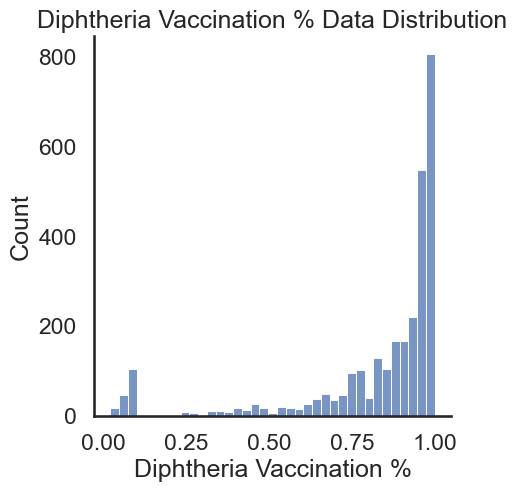

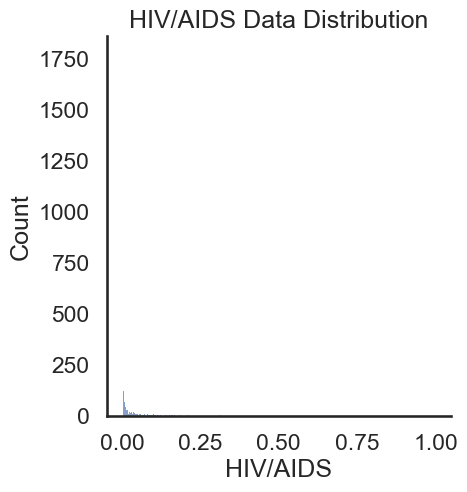

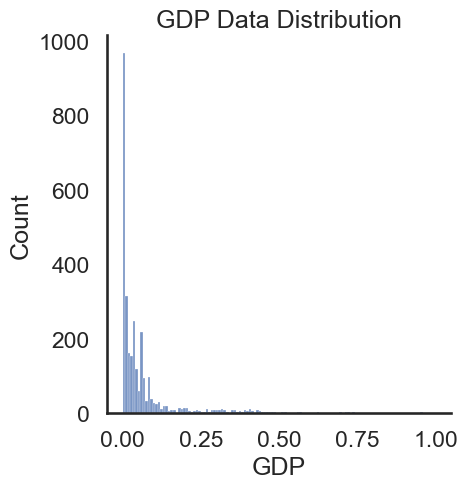

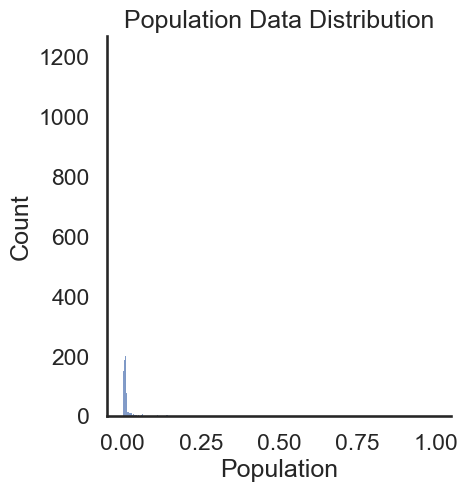

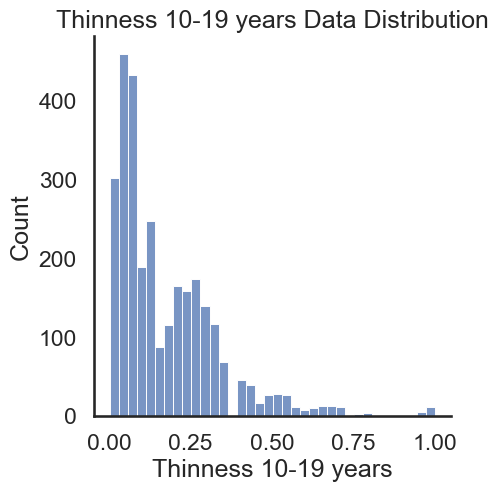

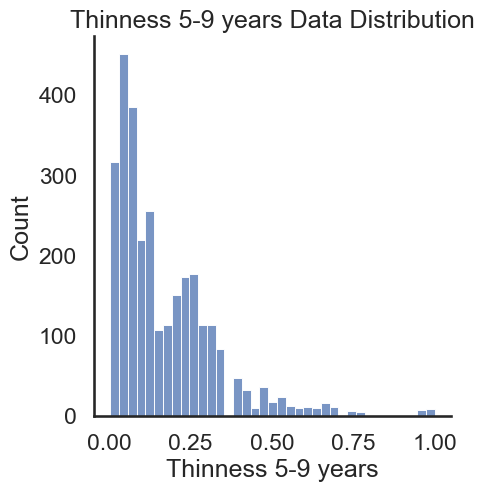

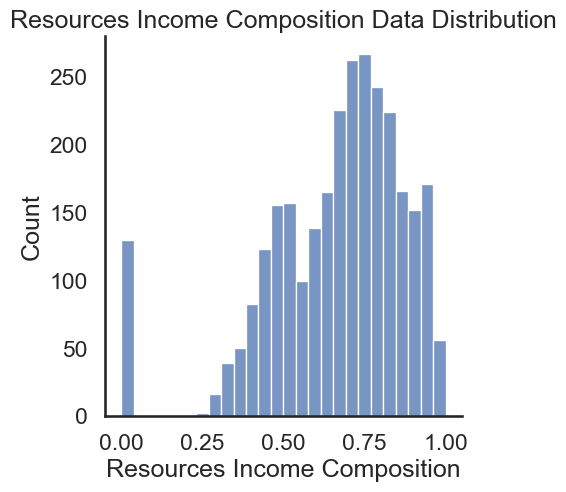

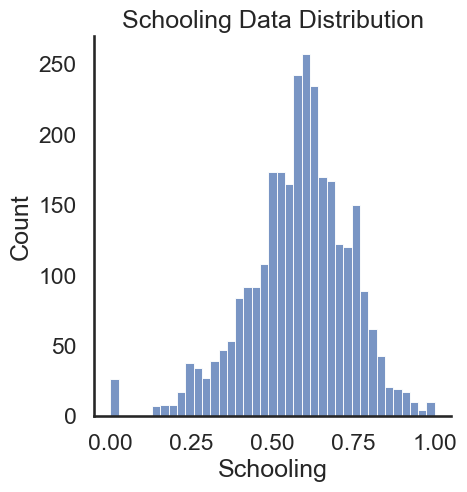

In [154]:
# Data Distribution
plt.rcParams.update({'figure.max_open_warning': 0})
for col in categ_cols:                                             
    sns.countplot(x=col, data=df, dodge=True, palette="Set3")
    plt.title('%s Data Distribution'%col)
plt.show()
for i,col in enumerate(numeric_cols, 1): 
    sns.displot(x=df[col])
    plt.title('%s Data Distribution'%col)
plt.show()

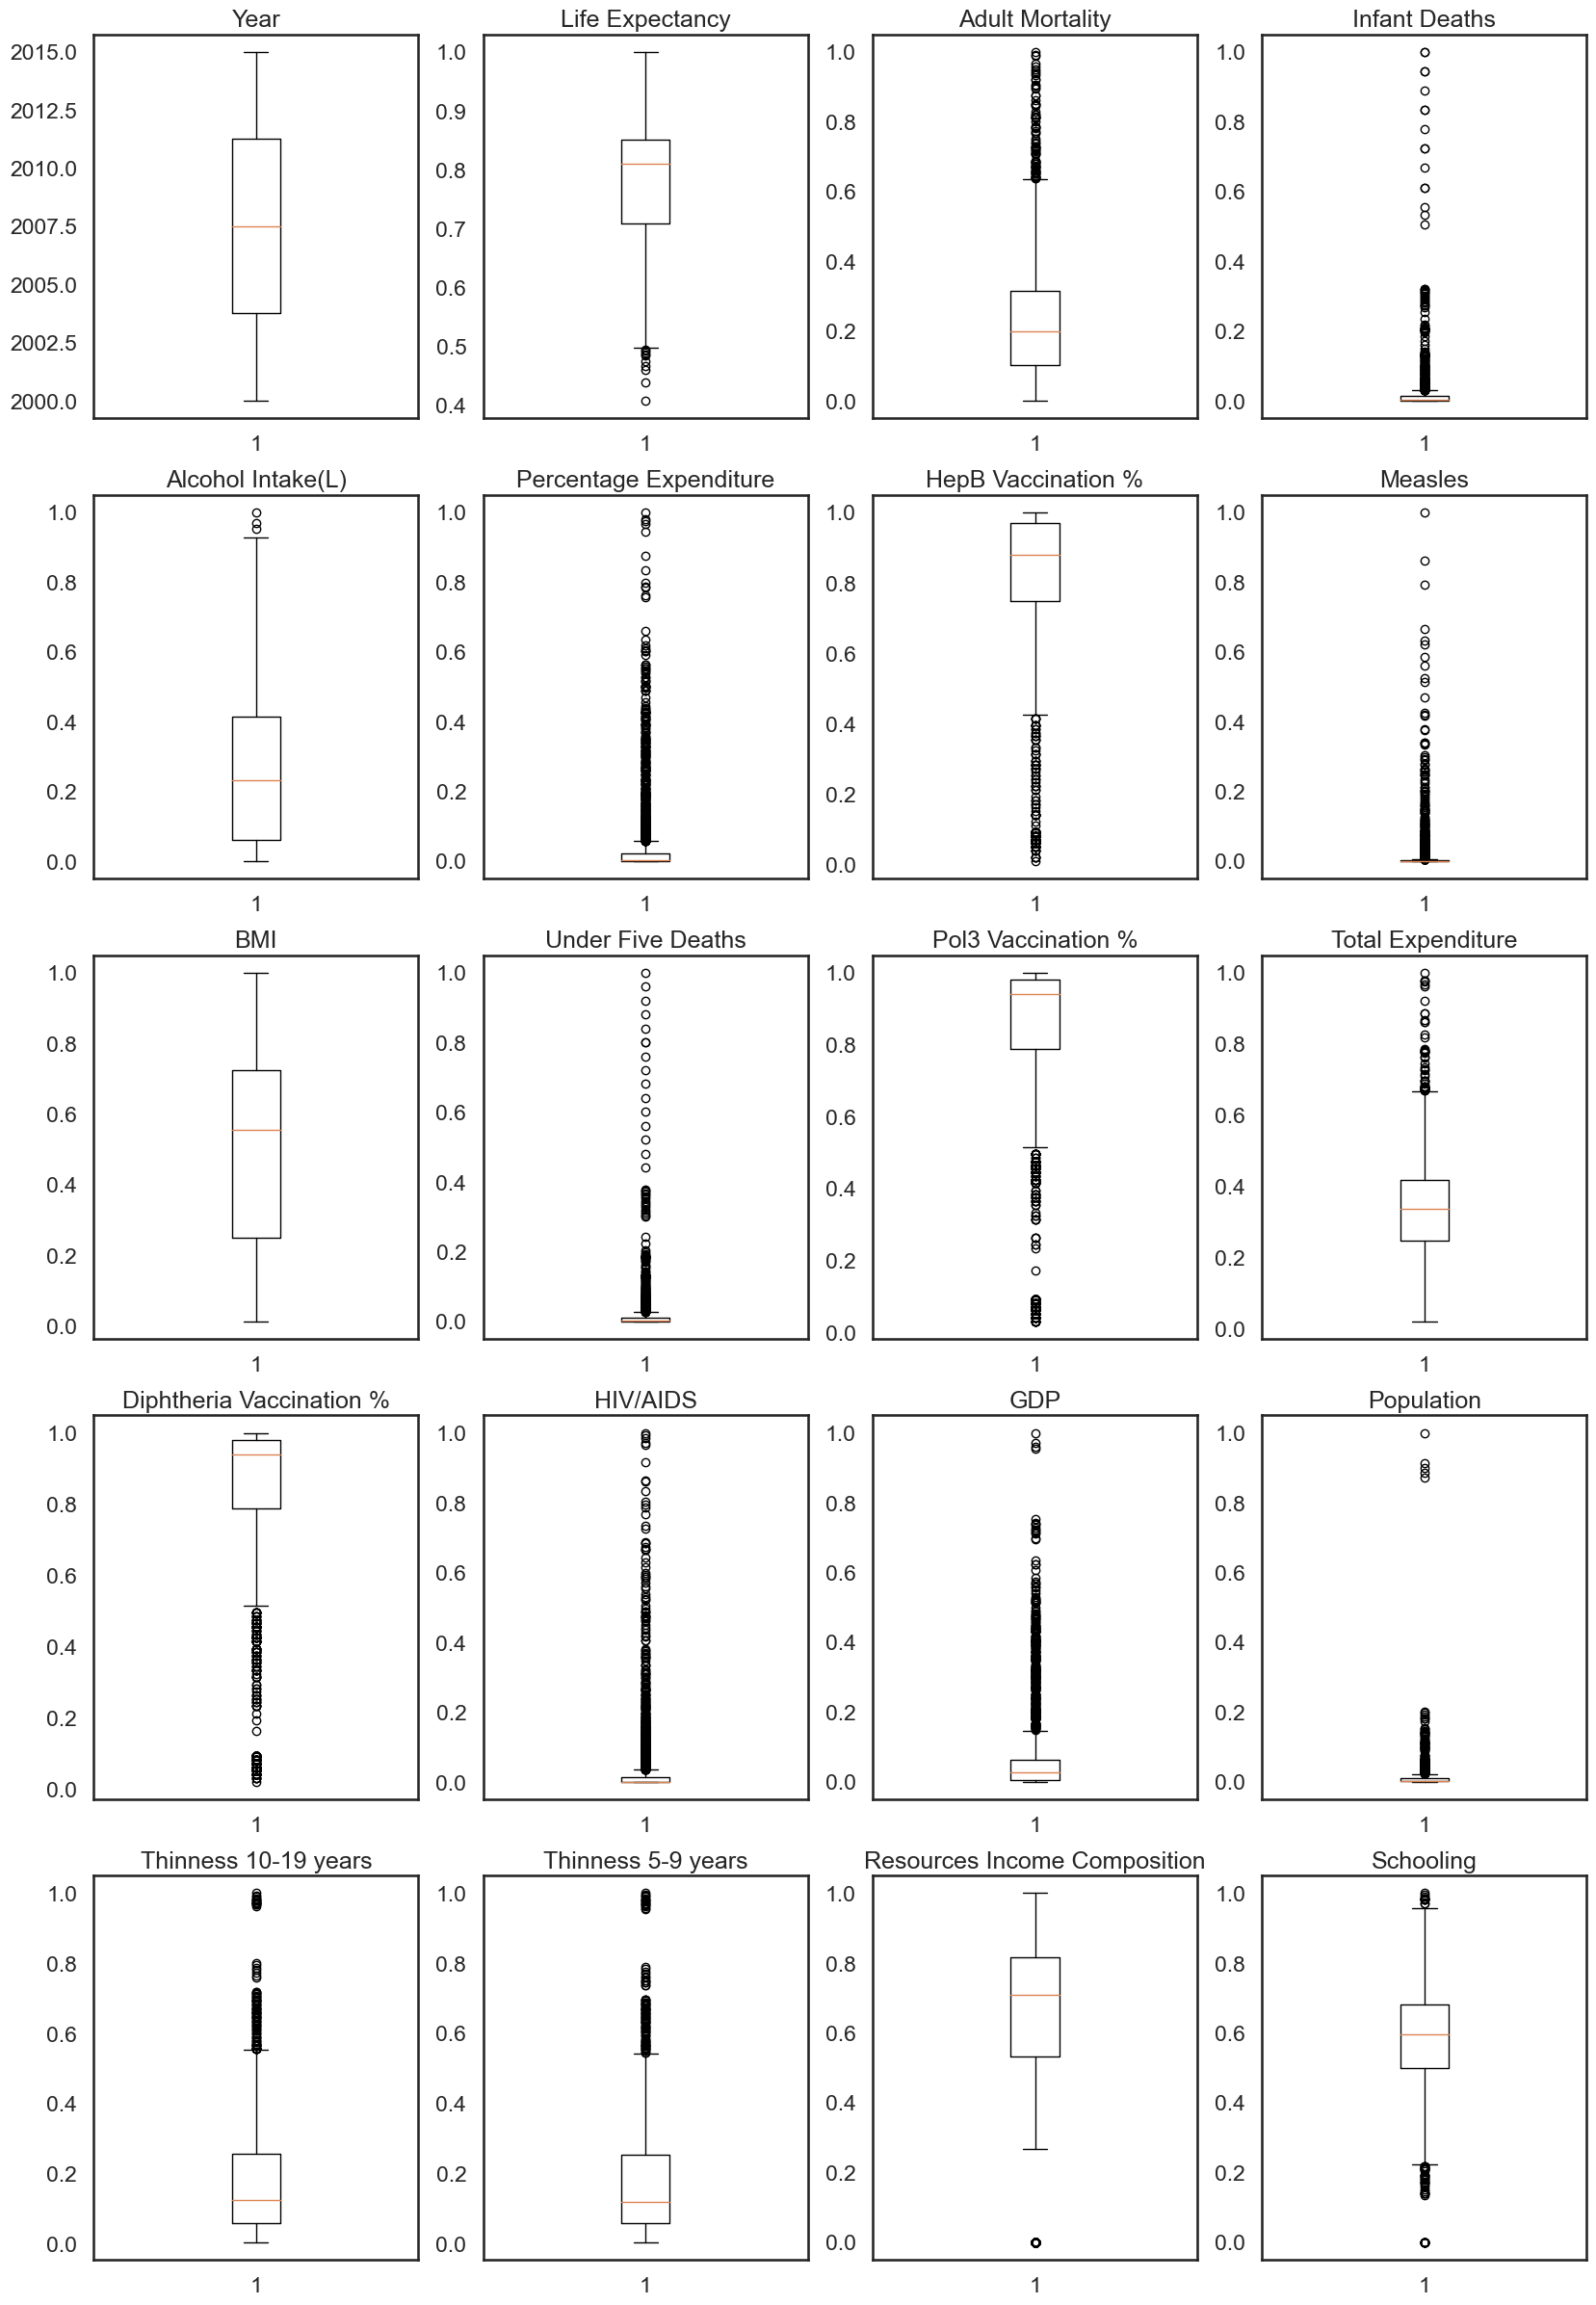

In [155]:
# Outliers 
plt.figure(figsize=(20,30))
for i,col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)
    plt.boxplot(df[col])
    plt.title(col)
plt.show()

In [156]:
# Outliers Lower & Upper Bound Percentage
percent_low = []
percent_high = []
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - (iqr*1.5)
    high = q3 + (iqr*1.5)
    count_l = len(np.where(df[col] < low)[0])
    count_h = len(np.where(df[col] > high)[0])
    percent_low.append(round(count_l/len(df[col])*100, 2))
    percent_high.append(round(count_h/len(df[col])*100, 2))
outlier_table = pd.DataFrame({'Factor':numeric_cols, 'Lower Bound %':percent_low, 'Upper Bound %':percent_high})
outlier_table

Factor  Lower Bound %  Upper Bound %
0                           Year           0.00           0.00
1                Life Expectancy           0.34           0.00
2                Adult Mortality           0.00           2.80
3                  Infant Deaths           0.00          11.13
4              Alcohol Intake(L)           0.00           0.10
5         Percentage Expenditure           0.00          13.25
6             HepB Vaccination %           7.51           0.00
7                        Measles           0.00          18.51
8                            BMI           0.00           0.00
9              Under Five Deaths           0.00          13.59
10            Pol3 Vaccination %           9.49           0.00
11             Total Expenditure           0.00           1.67
12      Diphtheria Vaccination %          10.14           0.00
13                      HIV/AIDS           0.00          18.51
14                           GDP           0.00          10.28
15                    Population           0.00           6.93
16          Thinness 10-19 years           0.00           3.42
17            Thinness 5-9 years           0.00           3.38
18  Resources Income Composition           4.44           0.00
19                     Schooling           2.05           0.41

In [157]:
# Effect of Outlier Trimming (remove outlier)
df_test = df.drop(['Country'], axis='columns')
df_test = df_test[~((df_test<low) | (df_test>high)).any(axis=1)]
df_test.shape

(0, 21)

In [158]:
# Winzorization 
for i,col in enumerate(numeric_cols, 1):
    df[col] = winsorize(df[col], (max(percent_low)/100, max(percent_high)/100))      

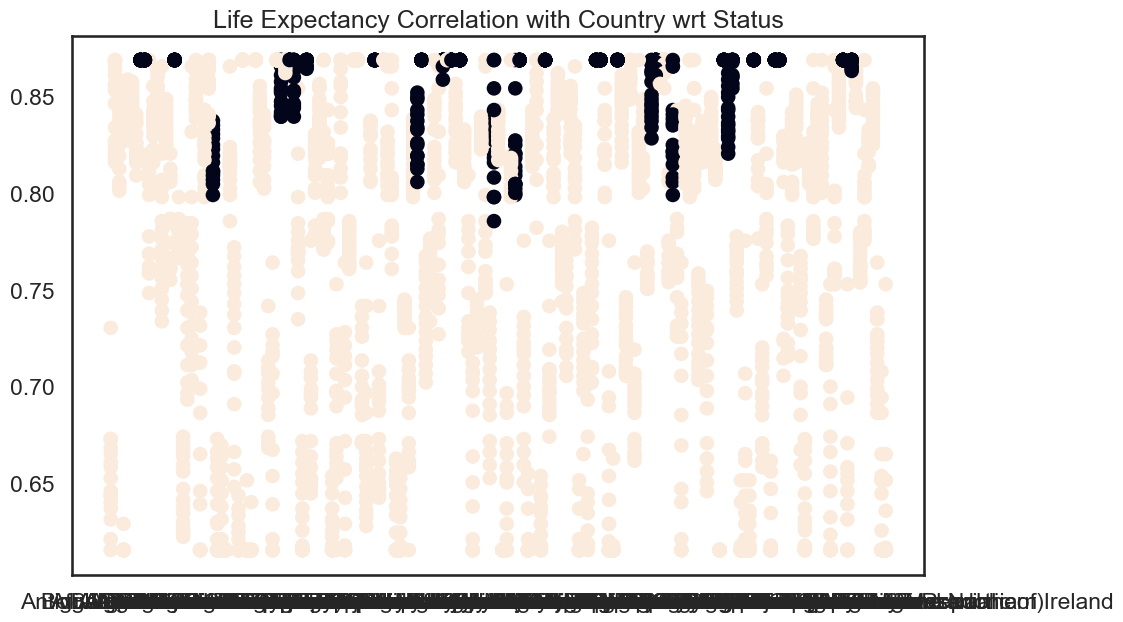

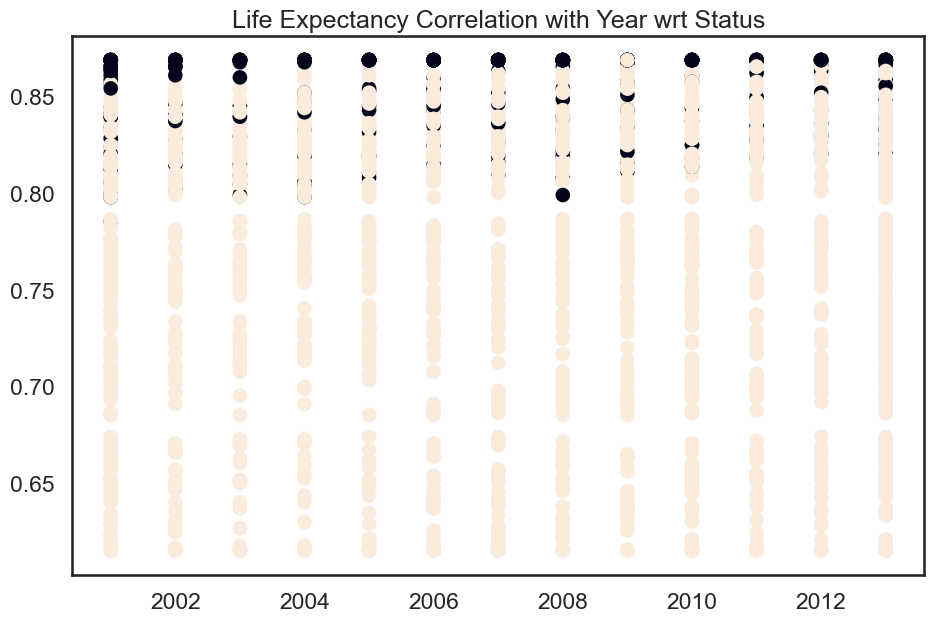

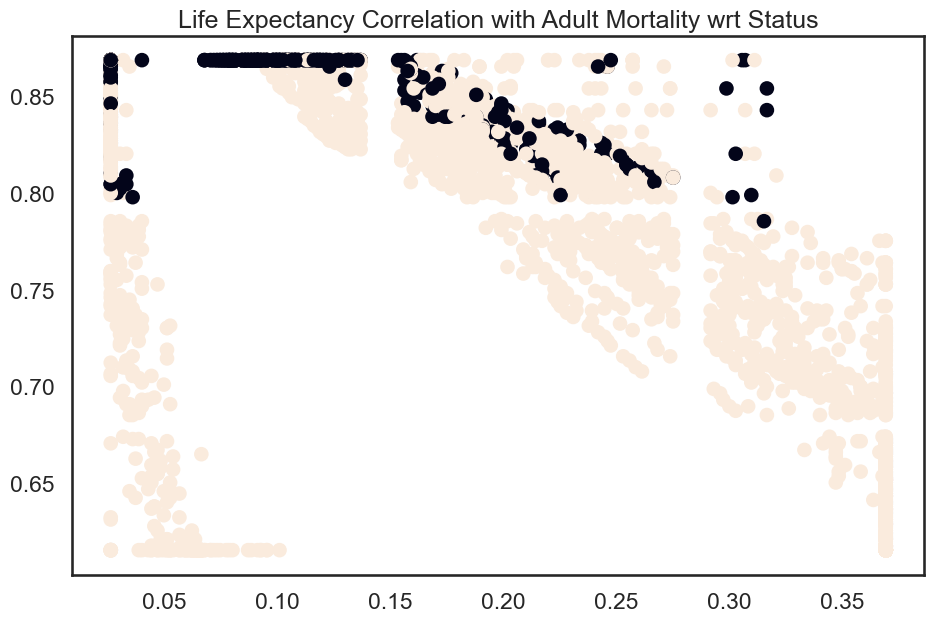

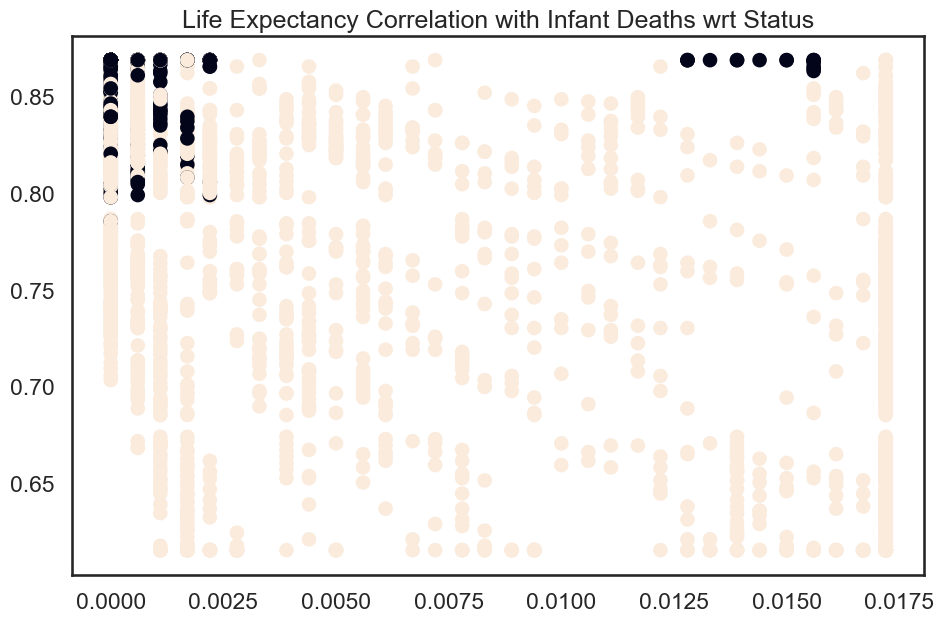

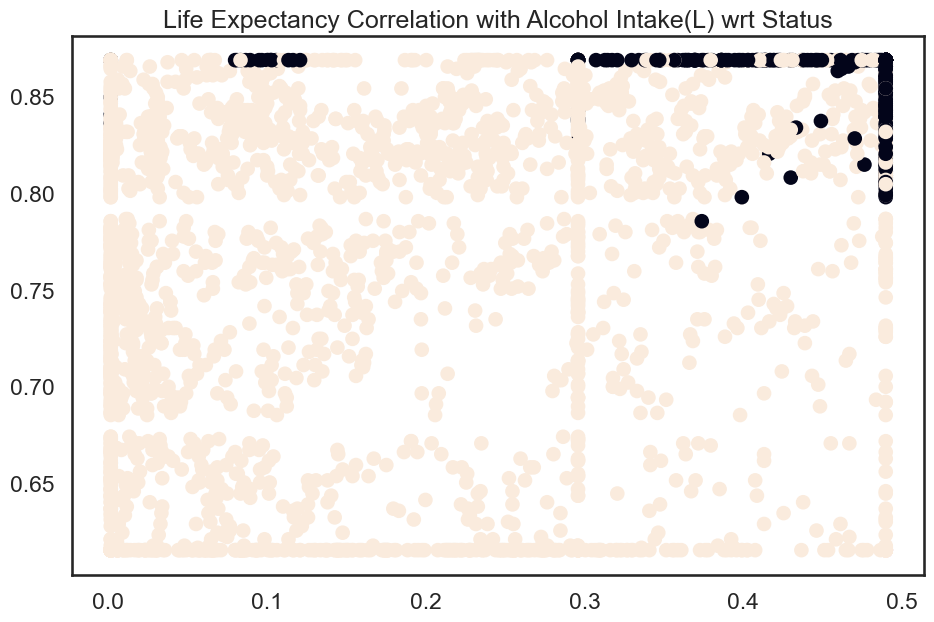

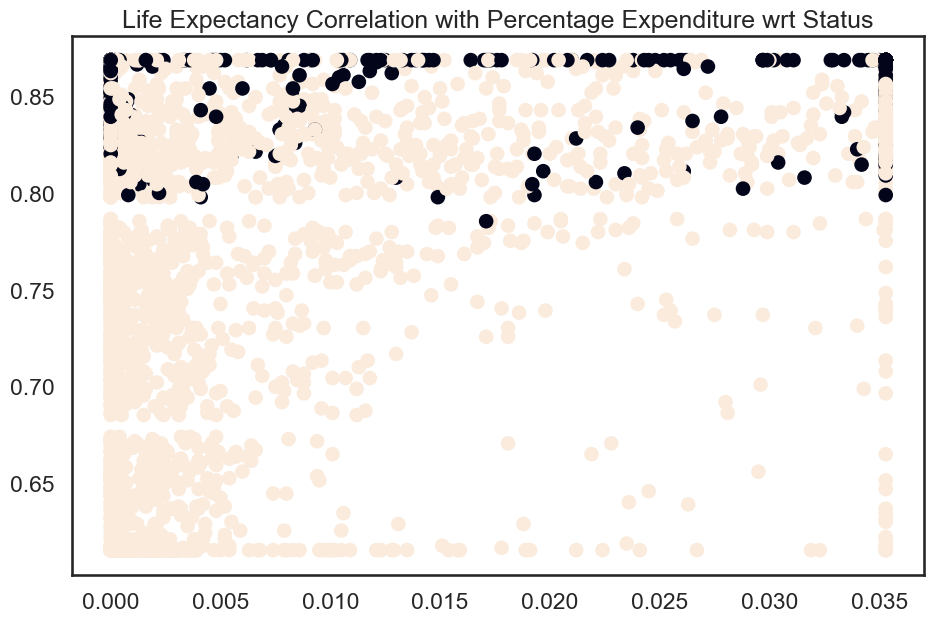

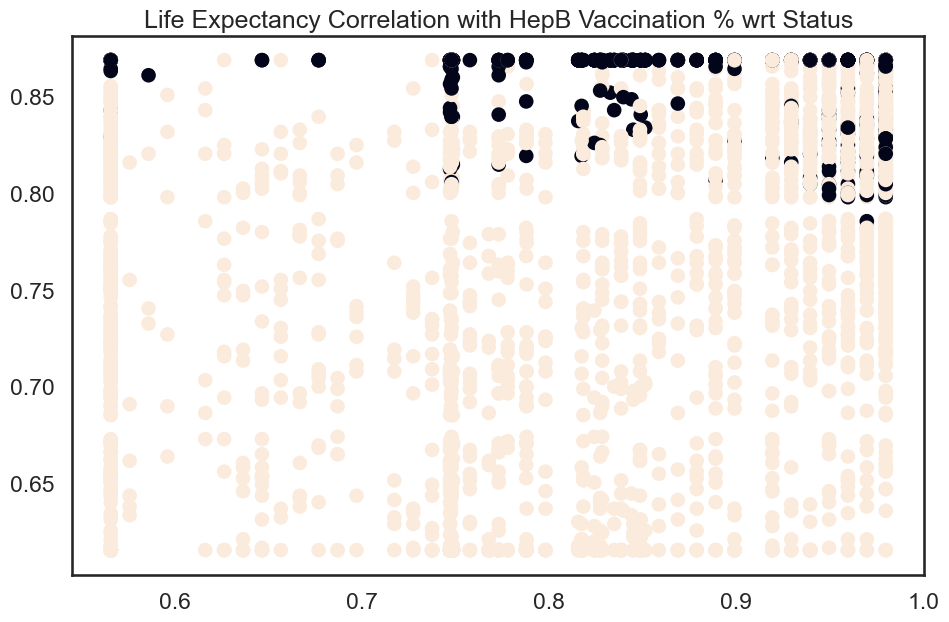

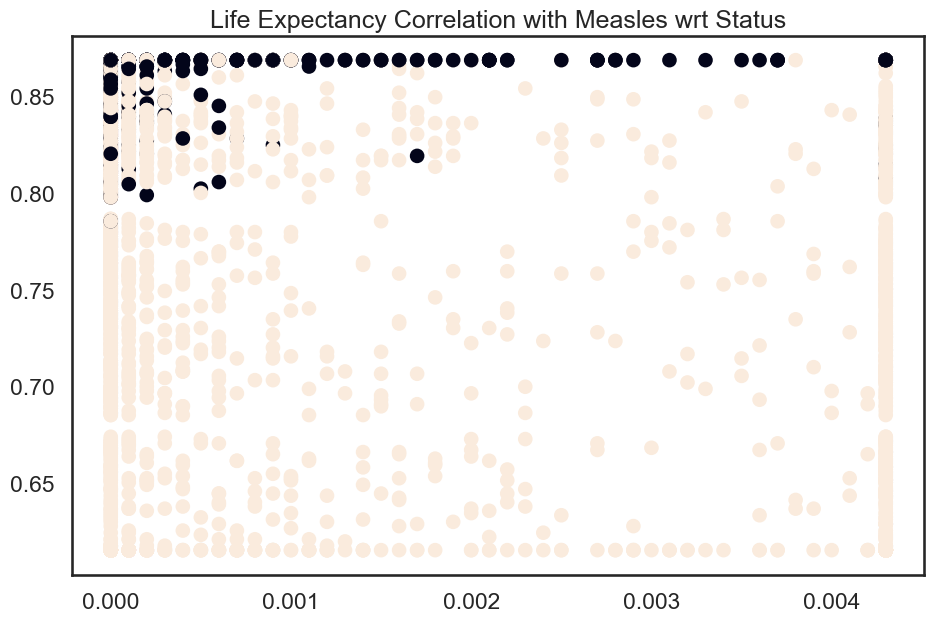

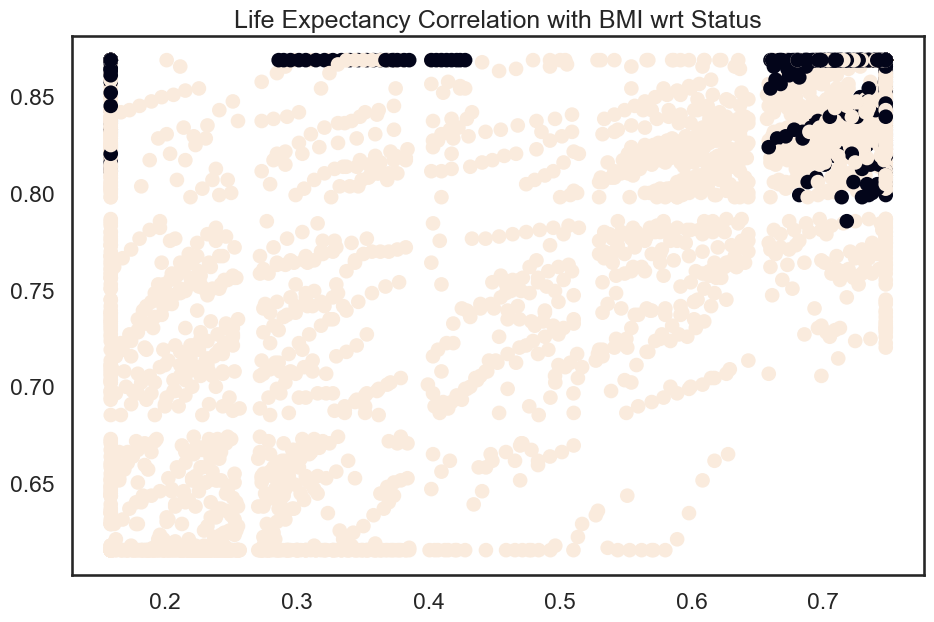

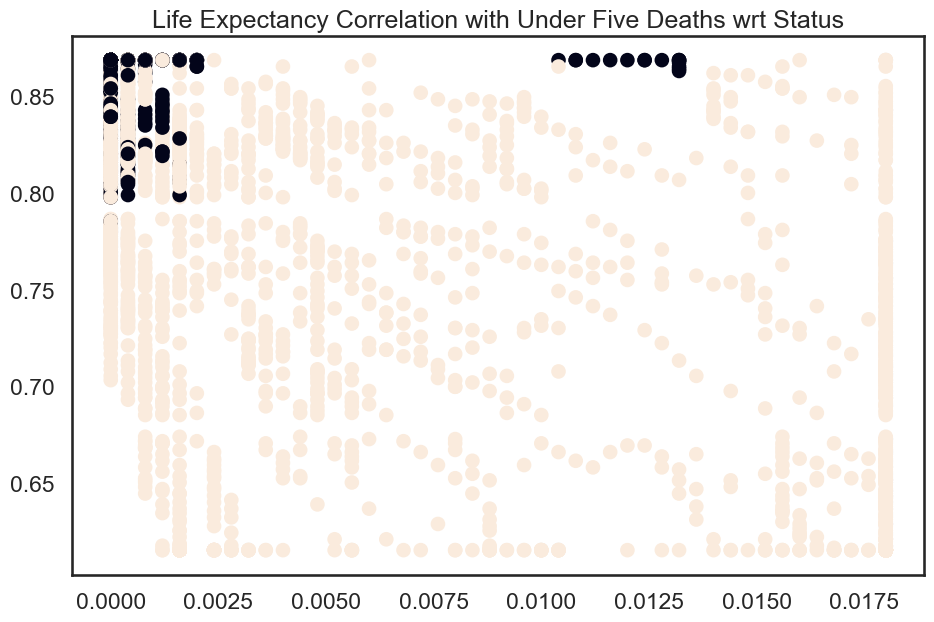

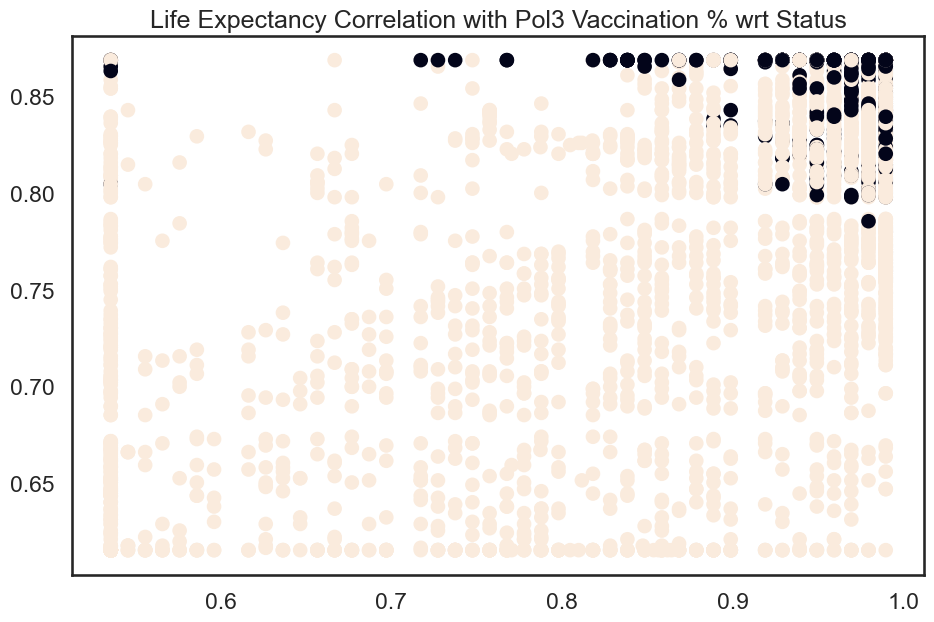

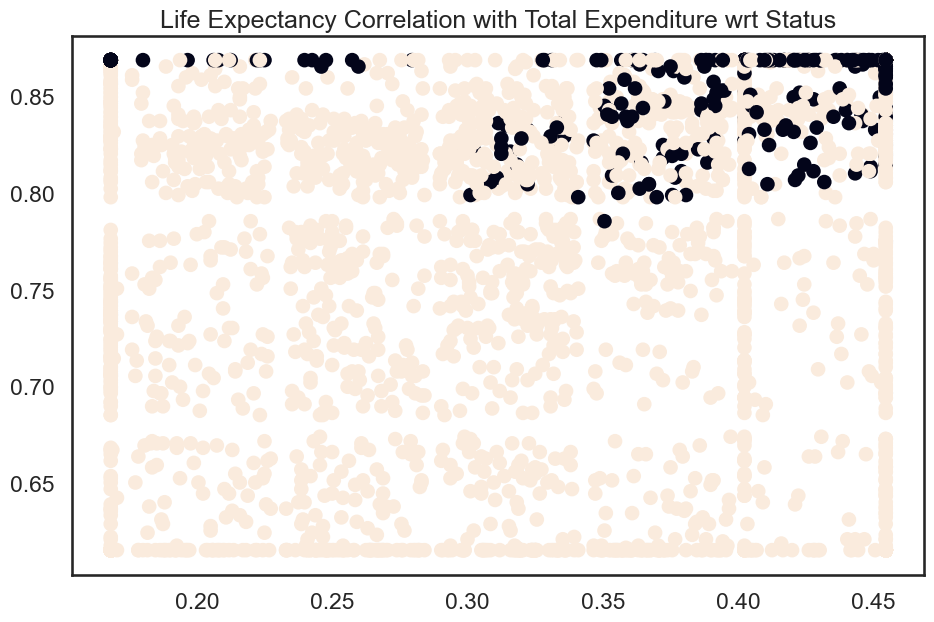

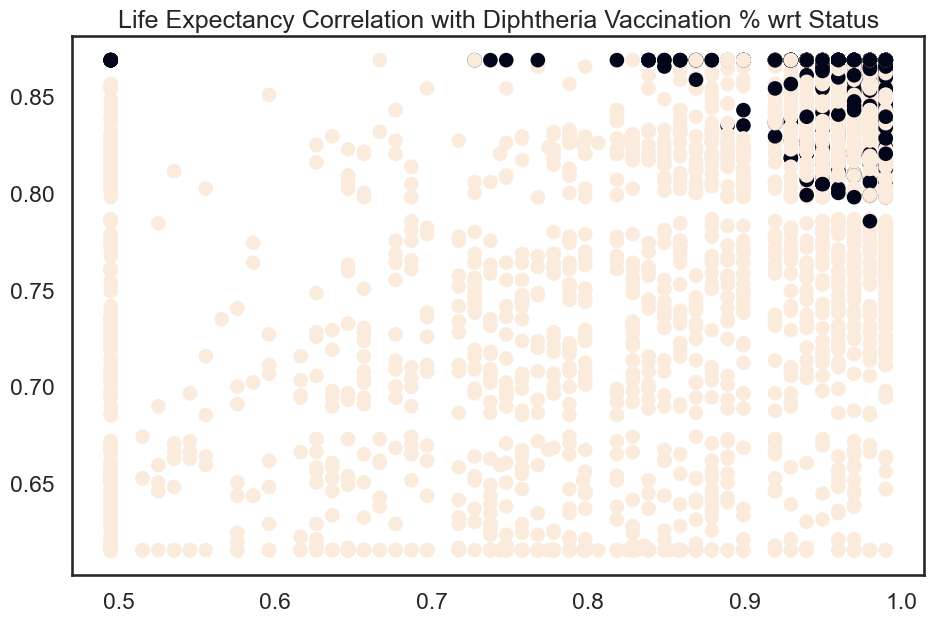

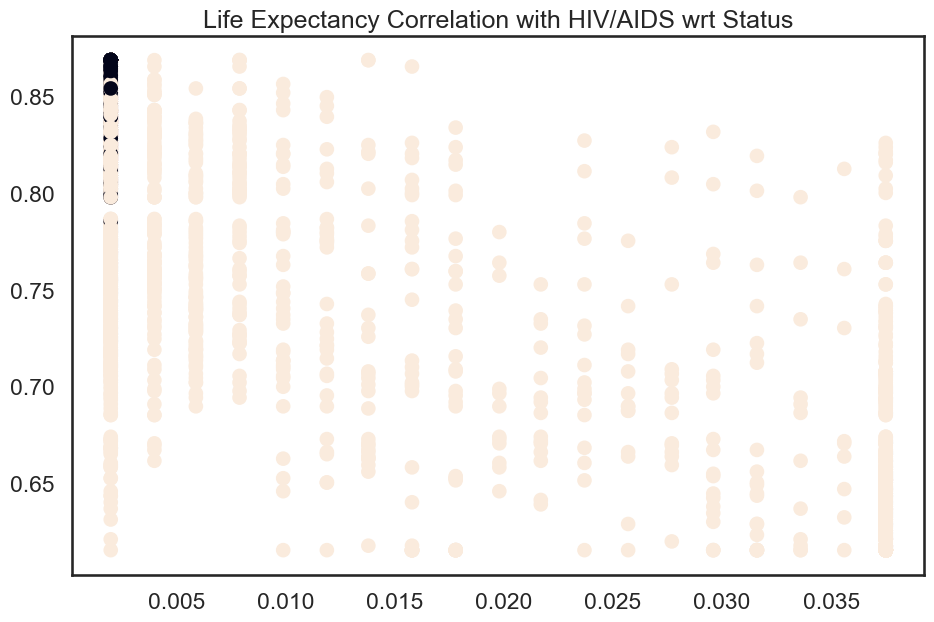

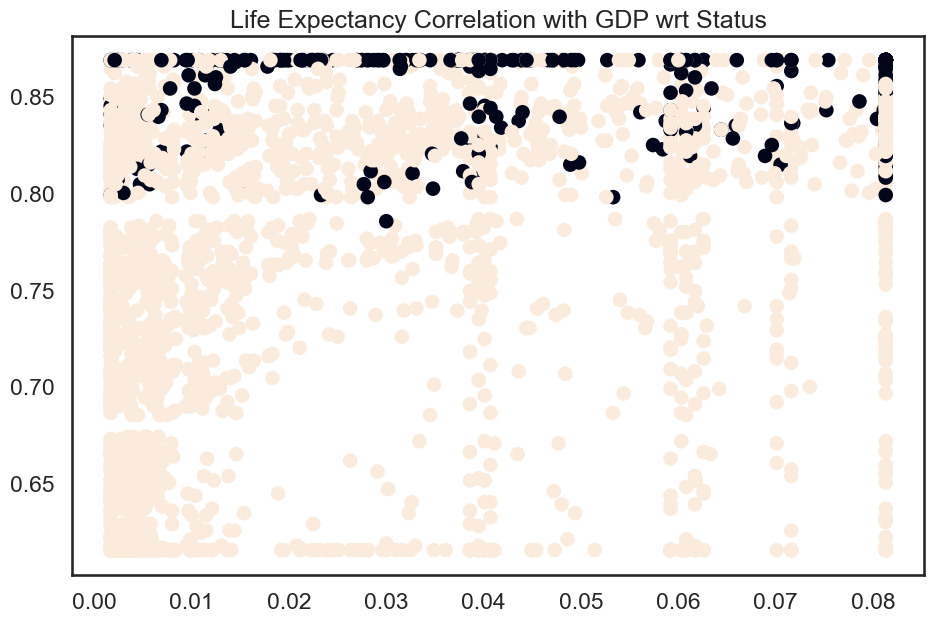

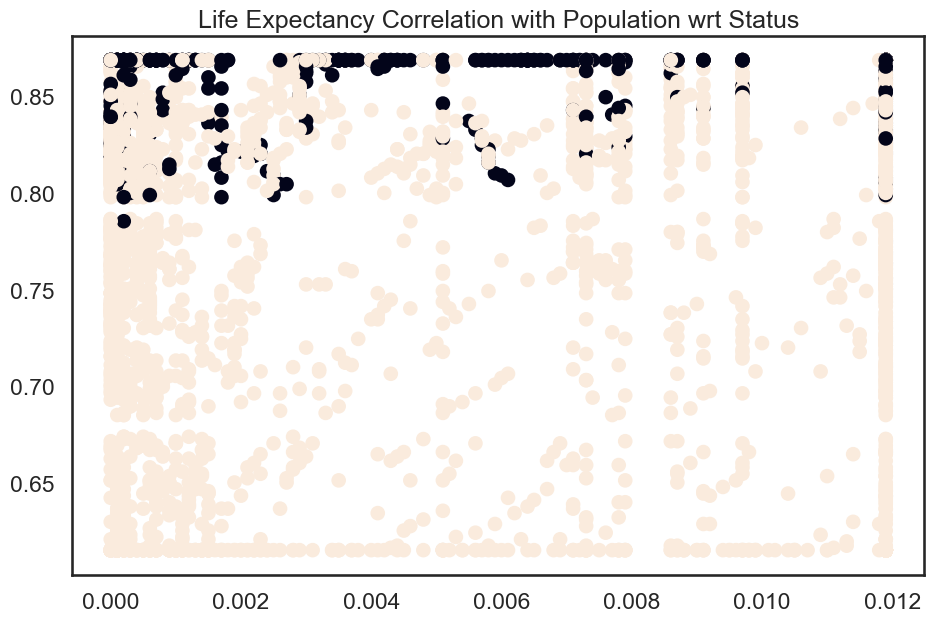

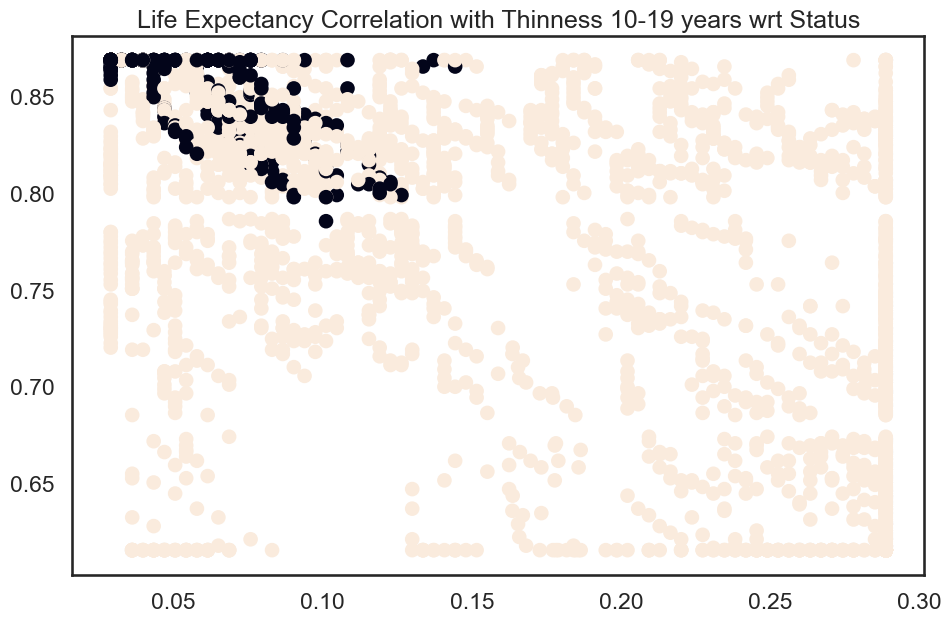

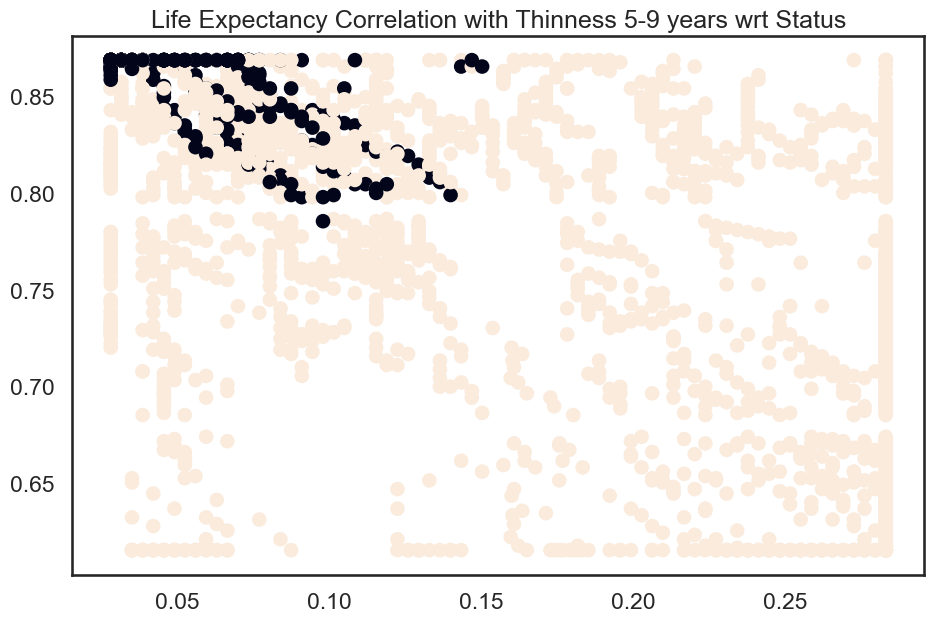

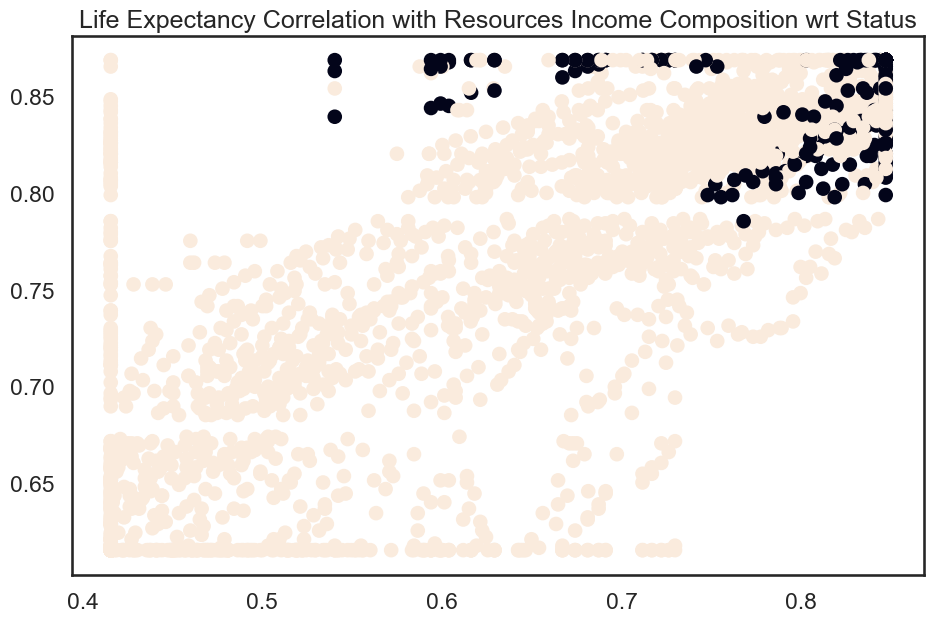

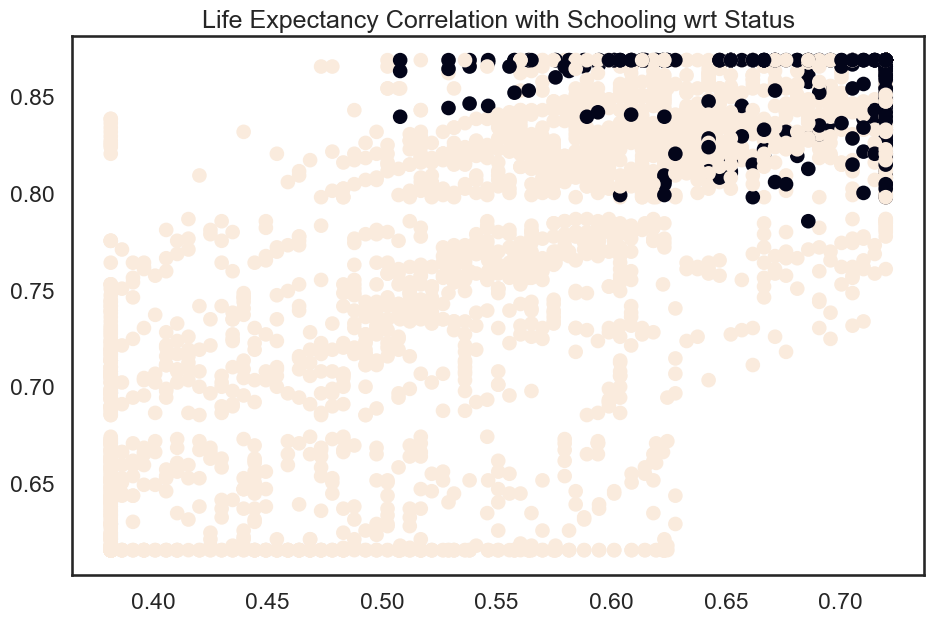

In [159]:
# Life Expectancy Correlation with Other Factors wrt Status
for col in df.columns:
    if col not in ('Life Expectancy', 'Status'):
        plt.scatter(x=df[col], y=df['Life Expectancy'], c=df['Status'], label=df['Status'])
        plt.title('Life Expectancy Correlation with %s wrt Status'%col)
        plt.show()

In [160]:
# Correlation Statistics
p_coef, p_val, rel, res = [], [], [], []
y = df['Life Expectancy']
for col in numeric_cols:
    #if col == 'Life Expectancy': continue
    coef, val = pearsonr(df[col], y)
    p_coef.append(coef)
    p_val.append(val)
    if coef > 0:
        if coef > 0.5: rel.append('Strong Positive')
        else: rel.append('Weak Positive')
    elif coef < 0:
        if coef < -0.5: rel.append('Strong Negative')
        else: rel.append('Weak Negative')
    else:
        rel.append('Nil')
    if val < 0.001:
        res.append('Strong')
    elif val < 0.05:
        res.append('Moderate')
    elif val < 0.1:
        res.append('Weak')
    else:
        res.append('Nil')
corelation_table = pd.DataFrame({'Factor':numeric_cols, 'Coefficient':p_coef, 'P-value':p_val, 'Relation':rel, 'Result Certainity':res}) 
corelation_table

Factor  Coefficient        P-value         Relation   
0                           Year     0.135249   1.995279e-13    Weak Positive  \
1                Life Expectancy     1.000000   0.000000e+00  Strong Positive   
2                Adult Mortality    -0.618528  9.991463e-309  Strong Negative   
3                  Infant Deaths    -0.601653  7.178289e-288  Strong Negative   
4              Alcohol Intake(L)     0.376892   1.771941e-99    Weak Positive   
5         Percentage Expenditure     0.470176  5.777633e-161    Weak Positive   
6             HepB Vaccination %     0.343389   8.178639e-82    Weak Positive   
7                        Measles    -0.355704   4.630663e-88    Weak Negative   
8                            BMI     0.618214  2.511886e-308  Strong Positive   
9              Under Five Deaths    -0.629115  1.778636e-322  Strong Negative   
10            Pol3 Vaccination %     0.592375  6.312709e-277  Strong Positive   
11             Total Expenditure     0.232269   3.659484e-37    Weak Positive   
12      Diphtheria Vaccination %     0.587059  8.150838e-271  Strong Positive   
13                      HIV/AIDS    -0.817159   0.000000e+00  Strong Negative   
14                           GDP     0.471798  3.258412e-162    Weak Positive   
15                    Population     0.016479   3.727358e-01    Weak Positive   
16          Thinness 10-19 years    -0.593871  1.146659e-278  Strong Negative   
17            Thinness 5-9 years    -0.597771  3.005295e-283  Strong Negative   
18  Resources Income Composition     0.810486   0.000000e+00  Strong Positive   
19                     Schooling     0.759332   0.000000e+00  Strong Positive   

   Result Certainity  
0             Strong  
1             Strong  
2             Strong  
3             Strong  
4             Strong  
5             Strong  
6             Strong  
7             Strong  
8             Strong  
9             Strong  
10            Strong  
11            Strong  
12            Strong  
13            Strong  
14            Strong  
15               Nil  
16            Strong  
17            Strong  
18            Strong  
19            Strong

In [161]:
# Important Variables Extraction
x = df.drop(['Year', 'Life Expectancy'], axis=1)
x.head(20)

Country  Status  Adult Mortality  Infant Deaths   
0                         Afghanistan       1           0.3638         0.0172  \
16                            Albania       1           0.1024         0.0000   
32                            Algeria       1           0.0263         0.0117   
48                             Angola       1           0.3693         0.0172   
64                Antigua and Barbuda       1           0.0263         0.0000   
80                          Argentina       1           0.1604         0.0044   
96                            Armenia       1           0.1632         0.0006   
112                         Australia       0           0.0816         0.0006   
128                           Austria       0           0.0899         0.0000   
144                        Azerbaijan       1           0.1632         0.0028   
160                           Bahamas       1           0.2033         0.0000   
176                           Bahrain       1           0.0954         0.0000   
192                        Bangladesh       1           0.1784         0.0172   
208                          Barbados       1           0.1355         0.0000   
224                           Belarus       1           0.2711         0.0000   
240                           Belgium       0           0.1024         0.0000   
256                            Belize       1           0.2420         0.0000   
272                             Benin       1           0.3444         0.0139   
288                            Bhutan       1           0.2918         0.0000   
304  Bolivia (Plurinational State of)       1           0.2573         0.0044   

     Alcohol Intake(L)  Percentage Expenditure  HepB Vaccination %  Measles   
0               0.0017                  0.0037              0.6566   0.0043  \
16              0.2574                  0.0187              0.9798   0.0000   
32              0.2959                  0.0000              0.9596   0.0003   
48              0.2959                  0.0000              0.6465   0.0006   
64              0.2959                  0.0000              0.9798   0.0000   
80              0.2959                  0.0000              0.9495   0.0000   
96              0.2959                  0.0000              0.9495   0.0002   
112             0.2959                  0.0000              0.9394   0.0003   
128             0.2959                  0.0000              0.9394   0.0015   
144             0.2959                  0.0000              0.9697   0.0000   
160             0.2959                  0.0000              0.9596   0.0000   
176             0.2959                  0.0000              0.9798   0.0000   
192             0.2959                  0.0000              0.9798   0.0011   
208             0.2959                  0.0000              0.9798   0.0000   
224             0.2959                  0.0000              0.9798   0.0000   
240             0.2959                  0.0000              0.9798   0.0002   
256             0.2959                  0.0000              0.9495   0.0000   
272             0.2959                  0.0000              0.8283   0.0003   
288             0.2959                  0.0000              0.9798   0.0001   
304             0.2959                  0.0000              0.9798   0.0000   

        BMI  Under Five Deaths  Pol3 Vaccination %  Total Expenditure   
0    0.2461             0.0180              0.5354             0.4545  \
16   0.7474             0.0000              0.9899             0.3409   
32   0.7474             0.0096              0.9596             0.4023   
48   0.3003             0.0180              0.5354             0.4023   
64   0.6147             0.0000              0.8687             0.4023   
80   0.7474             0.0036              0.9394             0.4023   
96   0.7075             0.0004              0.9697             0.4023   
112  0.7474             0.0004              0.9394             0.4023   
128  0.7423

In [162]:
null_vals = x.isna().sum().reset_index()
print(null_vals)
x.to_csv('data.csv')

                           index  0
0                        Country  0
1                         Status  0
2                Adult Mortality  0
3                  Infant Deaths  0
4              Alcohol Intake(L)  0
5         Percentage Expenditure  0
6             HepB Vaccination %  0
7                        Measles  0
8                            BMI  0
9              Under Five Deaths  0
10            Pol3 Vaccination %  0
11             Total Expenditure  0
12      Diphtheria Vaccination %  0
13                      HIV/AIDS  0
14                           GDP  0
15                    Population  0
16          Thinness 10-19 years  0
17            Thinness 5-9 years  0
18  Resources Income Composition  0
19                     Schooling  0


In [163]:
# Perform one-hot encoding on the 'Country' column
x = pd.get_dummies(x, columns=['Country'])

# Convert boolean values to 1s and 0s in the encoded columns
encoded_columns = x.columns[x.columns.str.startswith('Country_')]
x[encoded_columns] = x[encoded_columns].astype(int)

# Display the updated DataFrame with encoded values and converted boolean values
x.head(20)

Status  Adult Mortality  Infant Deaths  Alcohol Intake(L)   
0         1           0.3638         0.0172             0.0017  \
16        1           0.1024         0.0000             0.2574   
32        1           0.0263         0.0117             0.2959   
48        1           0.3693         0.0172             0.2959   
64        1           0.0263         0.0000             0.2959   
80        1           0.1604         0.0044             0.2959   
96        1           0.1632         0.0006             0.2959   
112       0           0.0816         0.0006             0.2959   
128       0           0.0899         0.0000             0.2959   
144       1           0.1632         0.0028             0.2959   
160       1           0.2033         0.0000             0.2959   
176       1           0.0954         0.0000             0.2959   
192       1           0.1784         0.0172             0.2959   
208       1           0.1355         0.0000             0.2959   
224       1           0.2711         0.0000             0.2959   
240       0           0.1024         0.0000             0.2959   
256       1           0.2420         0.0000             0.2959   
272       1           0.3444         0.0139             0.2959   
288       1           0.2918         0.0000             0.2959   
304       1           0.2573         0.0044             0.2959   

     Percentage Expenditure  HepB Vaccination %  Measles     BMI   
0                    0.0037              0.6566   0.0043  0.2461  \
16                   0.0187              0.9798   0.0000  0.7474   
32                   0.0000              0.9596   0.0003  0.7474   
48                   0.0000              0.6465   0.0006  0.3003   
64                   0.0000              0.9798   0.0000  0.6147   
80                   0.0000              0.9495   0.0000  0.7474   
96                   0.0000              0.9495   0.0002  0.7075   
112                  0.0000              0.9394   0.0003  0.7474   
128                  0.0000              0.9394   0.0015  0.7423   
144                  0.0000              0.9697   0.0000  0.6765   
160                  0.0000              0.9596   0.0000  0.7474   
176                  0.0000              0.9798   0.0000  0.7474   
192                  0.0000              0.9798   0.0011  0.2358   
208                  0.0000              0.9798   0.0000  0.7023   
224                  0.0000              0.9798   0.0000  0.7474   
240                  0.0000              0.9798   0.0002  0.7474   
256                  0.0000              0.9495   0.0000  0.1585   
272                  0.0000              0.8283   0.0003  0.3312   
288                  0.0000              0.9798   0.0001  0.3157   
304                  0.0000              0.9798   0.0000  0.6778   

     Under Five Deaths  Pol3 Vaccination %  ...   
0               0.0180              0.5354  ...  \
16              0.0000              0.9899  ...   
32              0.0096              0.9596  ...   
48              0.0180              0.5354  ...   
64              0.0000              0.8687  ...   
80              0.0036              0.9394  ...   
96              0.0004              0.9697  ...   
112             0.0004              0.9394  ...   
128             0.0000              0.9394  ...   
144             0.0024              0.9899  ...   
160             0.0000              0.9596  ...   
176             0.0000              0.9899  ...   
192             0.0180              0.9798  ...   
208             0.0000              0.9798  ...   
224             0.0000              0.9899  ...   
240             0.0004              0.9899  ...   
256             0.0000              0.9495  ...   
272             0.0156              0.7879  ...   
288             0.0000              0.9899  ...   
304             0.0040              0.9899  ...   

     Country_United Republic of Tanzania  Country_United States of America   
0                                      

## model development

In [164]:
# Dataset Splitting into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [165]:
from sklearn.linear_model import LinearRegression

lrregressor = LinearRegression()
lrregressor.fit(X_train, y_train)
y_pred = lrregressor.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = math.sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_pred)
print("Root Mean squared error =", lr_mse)
print("R2 Score =", lr_r2)

Root Mean squared error = 0.00033708444995363227
R2 Score = 0.9547209301240723


In [166]:
from sklearn.tree import DecisionTreeRegressor
dtregressor = DecisionTreeRegressor(random_state = 0)
dtregressor.fit(X_train, y_train)

y_pred = dtregressor.predict(X_test)

dt_mse = mean_squared_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", dt_mse)
print("R2 Score =", dt_r2)

Mean squared error = 0.0006077134972677606
R2 Score = 0.9183685218611646


In [167]:
from sklearn.ensemble import RandomForestRegressor
rfregressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
rfregressor.fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", rf_mse)
print("R2 Score =", rf_r2)

Mean squared error = 0.0002899393161202189
R2 Score = 0.9610537283574133


In [168]:
from sklearn.svm import SVR
svregressor = SVR(kernel = 'rbf')
svregressor.fit(X_train, y_train)

y_pred = svregressor.predict(X_test)

sv_mse = mean_squared_error(y_test, y_pred)
sv_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", sv_mse)
print("R2 Score =", sv_r2)

Mean squared error = 0.00460283649773815
R2 Score = 0.3817212409613555


In [169]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", ridge_mse)
print("R2 Score =", ridge_r2)

Mean squared error = 0.0004075061407922658
R2 Score = 0.9452614944820483


In [170]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)

y_pred = kn.predict(X_test)

kn_mse = mean_squared_error(y_test, y_pred)
kn_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", kn_mse)
print("R2 Score =", kn_r2)

Mean squared error = 0.00035308507322404374
R2 Score = 0.9525716368558157


In [171]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

gb_mse = mean_squared_error(y_test, y_pred)
gb_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", gb_mse)
print("R2 Score =", gb_r2)

Mean squared error = 0.0004077223434773753
R2 Score = 0.9452324529273644


In [172]:
from sklearn.ensemble import AdaBoostRegressor
ab = AdaBoostRegressor()
ab.fit(X_train, y_train)

y_pred = ab.predict(X_test)

ab_mse = mean_squared_error(y_test, y_pred)
ab_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", ab_mse)
print("R2 Score =", ab_r2)

Mean squared error = 0.001124033742524491
R2 Score = 0.8490134968324174


In [173]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor()
et.fit(X_train, y_train)

y_pred = et.predict(X_test)

et_mse = mean_squared_error(y_test, y_pred)
et_r2 = r2_score(y_test, y_pred)
print("Mean squared error =", et_mse)
print("R2 Score =", et_r2)

Mean squared error = 0.000189445362483607
R2 Score = 0.9745526386436822


## Model Evaluation

In [174]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression','Support Vector Regression', 'Ridge Regression', 'K Neighbors Regression', 'Gradient Boosting Regression', 'Ada Boost Regression', 'Extra Trees Regression']
mse = [lr_mse, dt_mse, rf_mse, sv_mse, ridge_mse, kn_mse, gb_mse, ab_mse, et_mse]
x_ax = mse

<Axes: title={'center': 'MSE values comparison among different regression models'}, xlabel='MSE Values', ylabel='Algorithms'>

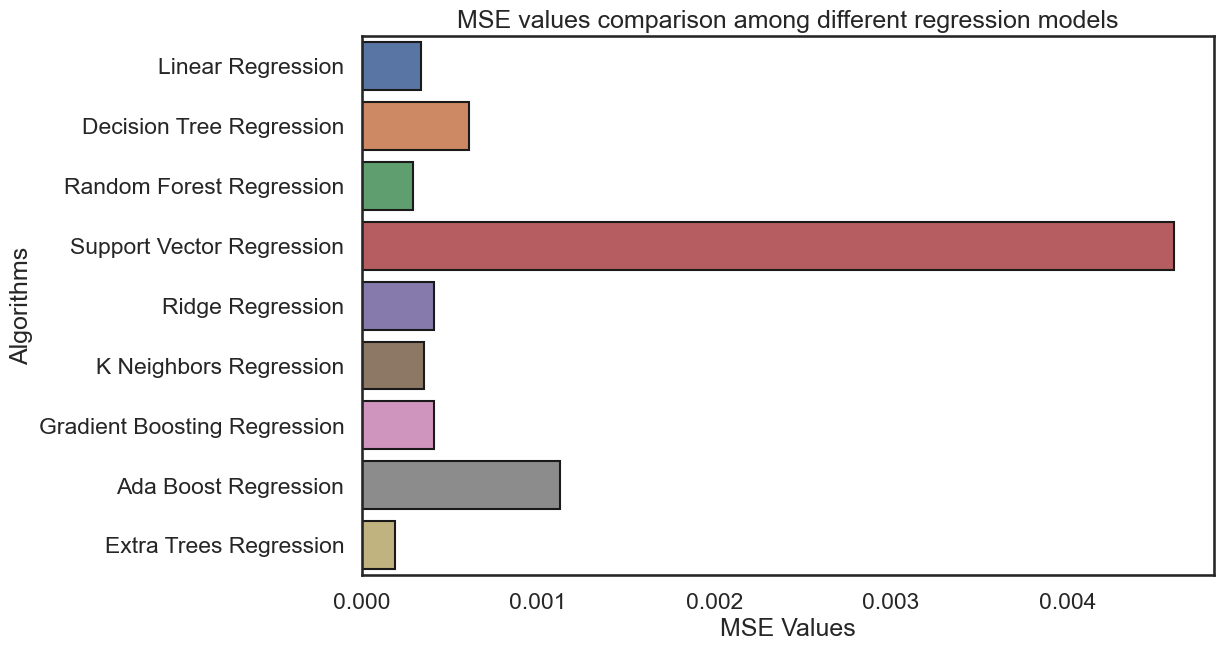

In [175]:
sns.set(rc={'figure.figsize':(11,7)})

sns.set_style("white")

sns.set_context("talk")
plt.xlabel("MSE Values")
plt.ylabel("Algorithms")
plt.title('MSE values comparison among different regression models')

sns.barplot(x = x_ax, y = y_ax, linewidth = 1.5, edgecolor = "0.1")

In [176]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression','Support Vector Regression', 'Ridge Regression', 'K Neighbors Regression', 'Gradient Boosting Regression', 'Ada Boost Regression', 'Extra Trees Regression']
r2 = [lr_r2, dt_r2, rf_r2, sv_r2, ridge_r2, kn_r2, gb_r2, ab_r2, et_r2]
x_ax = r2

<Axes: title={'center': 'R2 Scores comparison among different regression models'}, xlabel='R2 Scores', ylabel='Algorithms'>

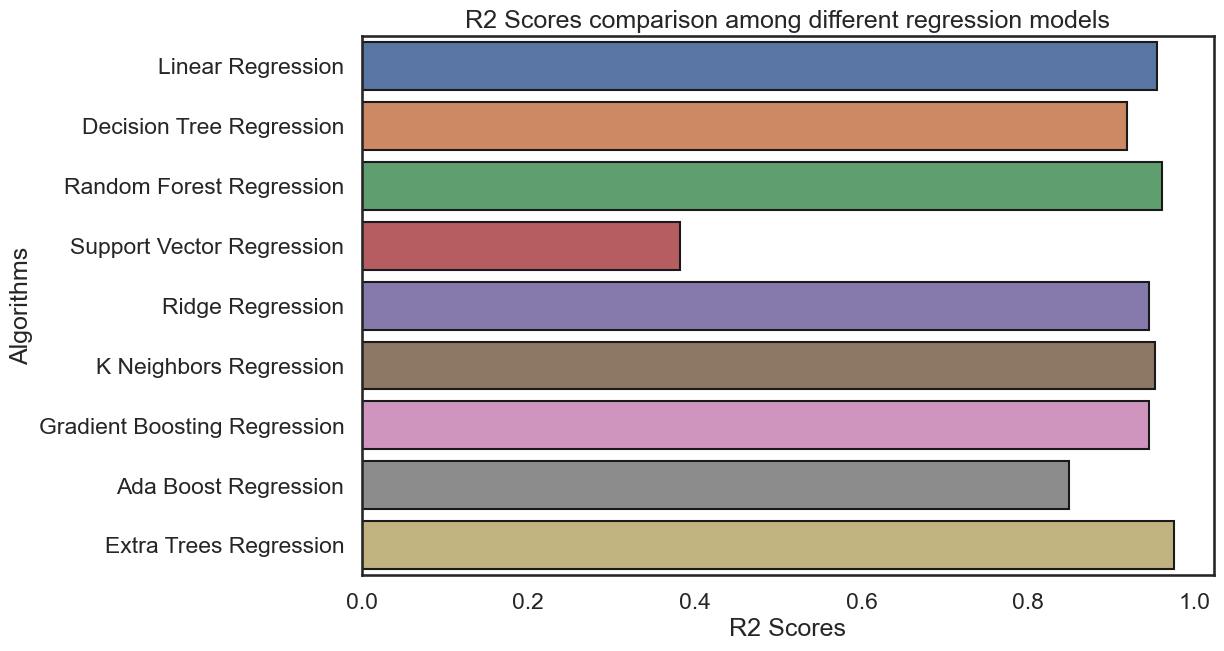

In [177]:
sns.set(rc={'figure.figsize':(11,7)})

sns.set_style("white")

sns.set_context("talk")
plt.xlabel("R2 Scores")
plt.ylabel("Algorithms")
plt.title('R2 Scores comparison among different regression models')

sns.barplot(x = x_ax, y = y_ax, linewidth = 1.5, edgecolor = "0.1")

In [178]:
df = pd.DataFrame({'Algorithms': y_ax, 'MSE Values': mse, 'R2 Values':r2})
df

Algorithms  MSE Values  R2 Values
0             Linear Regression    0.000337   0.954721
1      Decision Tree Regression    0.000608   0.918369
2      Random Forest Regression    0.000290   0.961054
3     Support Vector Regression    0.004603   0.381721
4              Ridge Regression    0.000408   0.945261
5        K Neighbors Regression    0.000353   0.952572
6  Gradient Boosting Regression    0.000408   0.945232
7          Ada Boost Regression    0.001124   0.849013
8        Extra Trees Regression    0.000189   0.974553

## Exporting model

In [179]:
import pickle
pickle.dump(et,open("lifeexpectancy.pkl","wb"))

## Life Expectancy Prediction Conclusion
After evaluating various models including linear regression and decision tree regression, we have determined that Extra Trees Regression yields the most accurate predictions for life expectancy. The Extra Trees Regression model achieved an impressive R2 value of 97.46%, indicating a strong correlation between the input features and the predicted life expectancy.